In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [24]:
df = pd.read_parquet('../../data/fhv_tripdata_2021-01.parquet')

df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PUlocationID', 'DOlocationID']
numerical = ['trip_distance']

# df[categorical] = df[categorical].astype(str)

In [25]:
df.keys()

Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number',
       'duration'],
      dtype='object')

In [5]:
#define fucntion to load, process data and output mean of duration
def load_prepare_doc(path,filter_df=True):
    '''
    input:str: path to records
    filter_df:bool: arg to filter the duration 
    '''
    categorical = ['PUlocationID', 'DOlocationID']
    df=pd.read_parquet(path) #load record
    print("Number of records", len(df))
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    print("mean of duration",df.duration.mean())
    sns.distplot(df.duration) # plot distribution
    if filter_df:
        df = df[(df.duration >= 1) & (df.duration <= 60)]
    return df[categorical+['duration']]
        

# Q1. Downloading the data
# Q2. Computing duration

Number of records 1154112
mean of duration 19.167224093791006


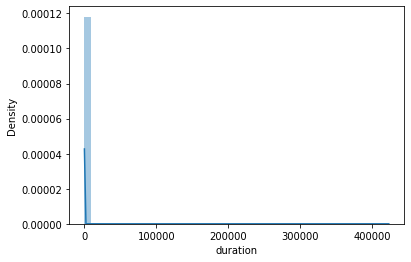

In [16]:
#loading January data
df_jan =load_prepare_doc('../../data/fhv_tripdata_2021-01.parquet',True)

Number of records 1037692
mean of duration 20.70698622520125


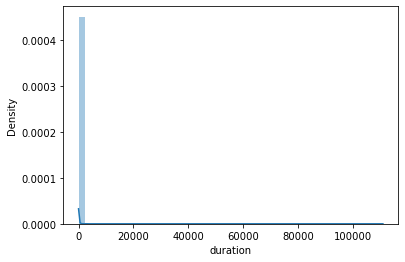

In [20]:
#loading February data
df_feb = load_prepare_doc('../data/fhv_tripdata_2021-02.parquet',True)

# Q3. Missing values

In [23]:
(df_jan['PUlocationID'].isnull().sum())/len(df_jan)
categorical = ['PUlocationID', 'DOlocationID']

In [17]:
#Janaury
df_jan['PUlocationID'].fillna( "-1",inplace=True)
df_jan['DOlocationID'].fillna( "-1",inplace=True)
df_jan[categorical] = df_jan[categorical].astype(str)

In [25]:
len(df_jan[df_jan['PUlocationID']=="-1"])/len(df_jan)

0.8352732770722617

In [26]:
#februray
df_feb['PUlocationID'].fillna( "-1",inplace=True)
df_feb['DOlocationID'].fillna( "-1",inplace=True)
df_feb[categorical] = df_feb[categorical].astype(str)

# Q4. One-hot encoding

In [18]:
train_dicts = df_jan[categorical].to_dict(orient='records')

In [19]:
#creatring vectorizer object
vectorizer=DictVectorizer()

In [20]:
#transform train dataset
X_train =  vectorizer.fit_transform(train_dicts)
X_train.shape

(1109826, 525)

# Q5. Training a model

In [21]:
target = 'duration'
y_train = df_jan[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519388409808

In [23]:
import pickle
with open('../../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((vectorizer, lr), f_out)

# Q6. Evaluating the model

In [33]:
test_dicts=  df_feb[categorical].to_dict(orient='records')
test =vectorizer.transform(test_dicts)

In [34]:
y_pred = lr.predict(test)

mean_squared_error(df_feb['duration'].values, y_pred, squared=False)

11.014283226749118